# Creating Opne Star Cluster

## Generating Cluster in XYZ coordinate

Simulating 200 cluster stars within 5.0 pc...
...done in 0.00s. Total generated candidates: 300
Simulating 10000 field stars outside 5.0 pc...
...done in 0.00s. Total generated candidates: 12000
Combining data...
Simulation complete.

DataFrame Head:
          x         y         z         vx         vy         vz  label
0 -4.932328 -0.358022 -7.778636  33.014315 -11.392916 -16.467007      0
1 -8.580791  9.488614  3.941581  -2.405313  13.260322  15.163028      0
2  3.452302 -4.654904  5.844743  -5.187018   9.764031  16.262254      0
3 -2.222822  0.181788 -5.113510  28.988601 -14.972813  15.069225      0
4 -5.148772 -4.061628  9.999725  -7.879827  -4.712747   0.338845      0

Total stars simulated: 10200
Cluster members (label 1): 200 (Max Radius: 5.0 pc)
Field stars (label 0): 10000 (Min Radius: 5.0 pc)

Generating visualizations...


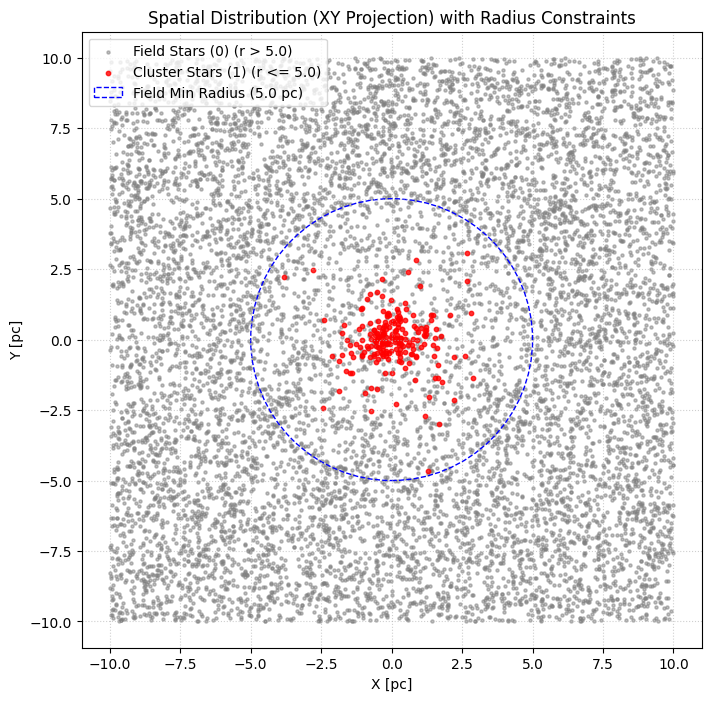

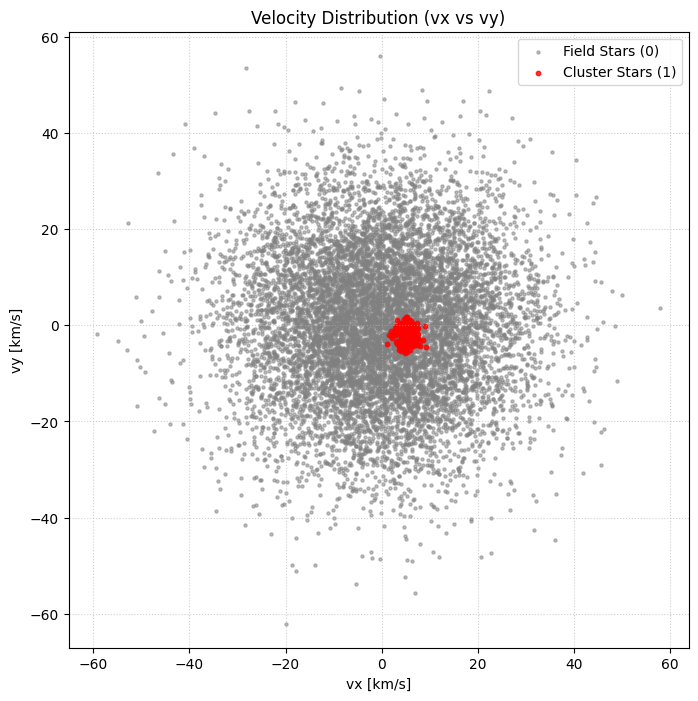

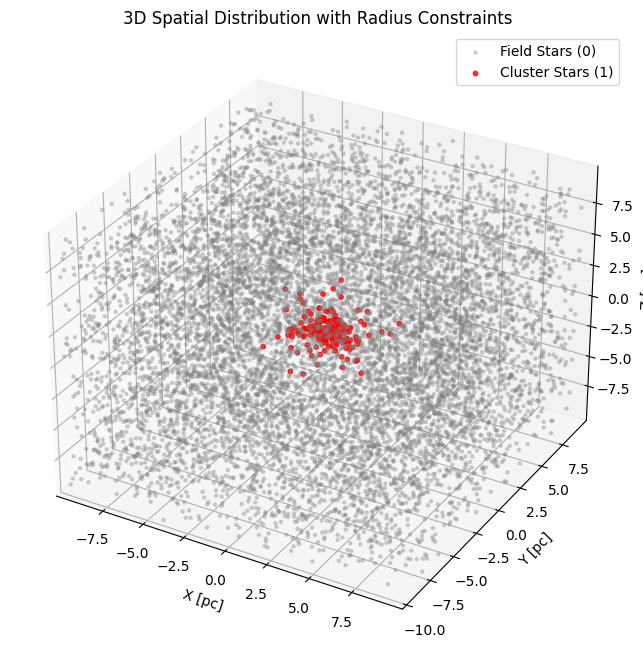

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting
import time # To show generation time

# --- Simulation Parameters ---

# Cluster Parameters
n_cluster = 200         # TARGET number of cluster members
cluster_center_pos = np.array([0.0, 0.0, 0.0]) # Cluster center position [pc]
a_plummer = 1.       # Plummer radius (characteristic size) [pc]
cluster_mean_vel = np.array([5.0, -2.0, 1.0]) # Cluster mean velocity [km/s]
cluster_vel_disp = 1.5  # Cluster internal velocity dispersion (1D) [km/s]
max_cluster_radius = 5.0 # <<< NEW: Maximum radius for a star to be considered cluster member [pc]

Speed_selection=0

# Field Parameters
n_field = 10000       # TARGET number of field stars
box_size = 20.0         # Size of the cubic simulation volume [pc]
field_min_pos = cluster_center_pos - box_size / 2.0
field_max_pos = cluster_center_pos + box_size / 2.0
field_mean_vel = np.array([0.0, 0.0, 0.0])   # Field mean velocity [km/s]
field_vel_disp = 15.0 # Field velocity dispersion (1D) [km/s]
min_field_radius = max_cluster_radius # <<< NEW: Minimum radius for field stars (set to exclude cluster region) [pc]
np.random.seed(420)
import numpy as np

def king_density(r, rc, rt):
    """King (1966) density profile normalized to 1 at r=0."""
    term = (1.0 / np.sqrt(1.0 + (r/rc)**2) - 
            1.0 / np.sqrt(1.0 + (rt/rc)**2))
    return np.where(r <= rt, term**2, 0.0)

def generate_king_cluster(N, rc, rt, random_seed=420):
    """
    Generate 3D positions of stars using the King profile.
    
    Parameters:
        N (int): Number of stars
        rc (float): Core radius (controls central density)
        rt (float): Tidal radius (cluster edge)
        random_seed (int): Optional random seed
        
    Returns:
        ndarray: (N, 3) array of (x, y, z) positions
    """
    np.random.seed(random_seed)
    r_max = rt  # Truncate at tidal radius
    max_density = king_density(0.0, rc, rt)  # Peak density at center
    
    # Rejection sampling for radii
    r_samples = []
    while len(r_samples) < N:
        # Propose radii uniformly up to rt
        r_proposed = np.random.uniform(0, r_max, size=N)
        # Compute densities at proposed radii
        densities = king_density(r_proposed, rc, rt)
        # Acceptance threshold
        u = np.random.uniform(0, max_density, size=N)
        # Accept/reject
        accepted = r_proposed[u <= densities]
        r_samples.extend(accepted.tolist())
    
    # Trim to desired N and convert to array
    r = np.array(r_samples[:N])
    
    # Generate isotropic angular coordinates
    theta = np.arccos(np.random.uniform(-1, 1, N))  # Polar angle
    phi = np.random.uniform(0, 2*np.pi, N)          # Azimuthal angle
    
    # Convert to Cartesian coordinates
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return np.column_stack((x, y, z))

def generate_fractal_cluster(N, num_levels=4, fractal_prob=0.7, 
                             initial_divisions=3, noise_scale=0.5, 
                             random_seed=None, final_radius=10.0):
    """
    Generates a 3D fractal star cluster using recursive subdivision.
    
    Parameters:
        N (int): Approximate number of stars (actual may vary slightly)
        num_levels (int): Number of subdivision levels (higher = more structure)
        fractal_prob (float): [0-1] Probability of subdividing a cell
        initial_divisions (int): Initial grid subdivisions at root level
        noise_scale (float): Position jitter relative to cell size
        final_radius (float): Cluster will be scaled to this radius (pc)
        random_seed (int): Seed for reproducibility
    
    Returns:
        ndarray: (M, 3) array of (x, y, z) positions (M ≈ N)
    """
    np.random.seed(random_seed)
    
    # Initial parent cube
    parent_size = 1.0
    positions = np.random.rand(initial_divisions**3, 3) * parent_size - parent_size/2
    
    for level in range(num_levels):
        new_positions = []
        cell_size = parent_size / (2**(level + 1))
        
        for pos in positions:
            if np.random.rand() < fractal_prob:
                # Subdivide into 2x2x2 grid for this cell
                sub_cell = pos[:, None] + (np.indices((2,2,2)).T.reshape(-1,3) * cell_size/2 - cell_size/4)
                new_positions.extend(sub_cell)
        
        if new_positions:
            positions = np.array(new_positions)
            # Add jitter to avoid perfect grid alignment
            positions += np.random.normal(0, noise_scale*cell_size, positions.shape)
    
    # Trim to approximate N points
    if len(positions) > N:
        positions = positions[:N]
    else:
        while len(positions) < N:
            positions = np.vstack([positions, positions[:N-len(positions)]])
    
    # Apply radial scaling to final radius
    max_r = np.max(np.linalg.norm(positions, axis=1))
    positions *= final_radius / max_r
    
    return positions


# --- Helper Function: Generate Plummer Sphere Positions (Unchanged) ---
def generate_plummer_positions(n_stars, center, radius):
    """Generates 3D positions following a Plummer distribution."""
    u = np.random.uniform(low=np.finfo(float).eps, high=1.0, size=n_stars)
    r = radius / np.sqrt(u**(-2./3.) - 1.)
    theta = np.arccos(1 - 2 * np.random.uniform(size=n_stars)) # Inclination
    phi = 2 * np.pi * np.random.uniform(size=n_stars)        # Azimuth
    dx = r * np.sin(theta) * np.cos(phi)
    dy = r * np.sin(theta) * np.sin(phi)
    dz = r * np.cos(theta)
    x = center[0] + dx
    y = center[1] + dy
    z = center[2] + dz
    return x, y, z

# --- REVISED: Simulate Cluster Stars with Radius Constraint ---
print(f"Simulating {n_cluster} cluster stars within {max_cluster_radius:.1f} pc...")
start_time = time.time()
collected_cluster_x, collected_cluster_y, collected_cluster_z = [], [], []
collected_cluster_vx, collected_cluster_vy, collected_cluster_vz = [], [], []
n_collected_cluster = 0
n_attempts = 0
batch_size_factor = 1.5 # Generate slightly more than needed in each batch

while n_collected_cluster < n_cluster:
    n_needed = n_cluster - n_collected_cluster
    # Estimate how many to generate, accounting for rejection rate (can be tuned)
    n_generate = max(n_needed, int(n_needed * batch_size_factor))
    n_attempts += n_generate

    # Generate candidate positions
    cand_x, cand_y, cand_z = generate_plummer_positions(
        n_generate, cluster_center_pos, a_plummer
    )
    # Calculate distance from center for candidates
    cand_r = np.sqrt(
        (cand_x - cluster_center_pos[0])**2 +
        (cand_y - cluster_center_pos[1])**2 +
        (cand_z - cluster_center_pos[2])**2
    )
    # Create filter mask
    mask = cand_r <= max_cluster_radius

    # Keep only candidates within the radius
    valid_x = cand_x[mask]
    valid_y = cand_y[mask]
    valid_z = cand_z[mask]
    n_valid = len(valid_x)

    # Generate velocities ONLY for the valid stars
    if n_valid > 0:
        valid_vx = np.random.normal(loc=cluster_mean_vel[0], scale=cluster_vel_disp, size=n_valid)
        valid_vy = np.random.normal(loc=cluster_mean_vel[1], scale=cluster_vel_disp, size=n_valid)
        valid_vz = np.random.normal(loc=cluster_mean_vel[2], scale=cluster_vel_disp, size=n_valid)

        # Add to collected lists (taking only up to n_needed)
        n_take = min(n_valid, n_needed)
        collected_cluster_x.extend(valid_x[:n_take])
        collected_cluster_y.extend(valid_y[:n_take])
        collected_cluster_z.extend(valid_z[:n_take])
        collected_cluster_vx.extend(valid_vx[:n_take])
        collected_cluster_vy.extend(valid_vy[:n_take])
        collected_cluster_vz.extend(valid_vz[:n_take])
        n_collected_cluster += n_take

# Convert lists to arrays
cluster_x = np.array(collected_cluster_x)
cluster_y = np.array(collected_cluster_y)
cluster_z = np.array(collected_cluster_z)
cluster_vx = np.array(collected_cluster_vx)
cluster_vy = np.array(collected_cluster_vy)
cluster_vz = np.array(collected_cluster_vz)
cluster_labels = np.ones(n_cluster, dtype=int)

end_time = time.time()
print(f"...done in {end_time - start_time:.2f}s. Total generated candidates: {n_attempts}")


# --- REVISED: Simulate Field Stars Excluding Core Region ---
print(f"Simulating {n_field} field stars outside {min_field_radius:.1f} pc...")
start_time = time.time()
collected_field_x, collected_field_y, collected_field_z = [], [], []
collected_field_vx, collected_field_vy, collected_field_vz = [], [], []
n_collected_field = 0
n_attempts_field = 0
batch_size_factor_field = 1.2 # Expect lower rejection rate here unless min_field_radius is large

while n_collected_field < n_field:
    n_needed = n_field - n_collected_field
    n_generate = max(n_needed, int(n_needed * batch_size_factor_field))
    n_attempts_field += n_generate

    # Generate candidate positions uniformly in the box
    cand_x = np.random.uniform(low=field_min_pos[0], high=field_max_pos[0], size=n_generate)
    cand_y = np.random.uniform(low=field_min_pos[1], high=field_max_pos[1], size=n_generate)
    cand_z = np.random.uniform(low=field_min_pos[2], high=field_max_pos[2], size=n_generate)

    # Calculate distance from center for candidates
    cand_r = np.sqrt(
        (cand_x - cluster_center_pos[0])**2 +
        (cand_y - cluster_center_pos[1])**2 +
        (cand_z - cluster_center_pos[2])**2
    )
    # Create filter mask
    mask = cand_r > min_field_radius

    # Keep only candidates outside the radius
    valid_x = cand_x[mask]
    valid_y = cand_y[mask]
    valid_z = cand_z[mask]
    n_valid = len(valid_x)

    # Generate velocities ONLY for the valid stars
    if n_valid > 0:
        valid_vx = np.random.normal(loc=field_mean_vel[0], scale=field_vel_disp, size=n_valid)
        valid_vy = np.random.normal(loc=field_mean_vel[1], scale=field_vel_disp, size=n_valid)
        valid_vz = np.random.normal(loc=field_mean_vel[2], scale=field_vel_disp, size=n_valid)

        # Add to collected lists (taking only up to n_needed)
        n_take = min(n_valid, n_needed)
        collected_field_x.extend(valid_x[:n_take])
        collected_field_y.extend(valid_y[:n_take])
        collected_field_z.extend(valid_z[:n_take])
        collected_field_vx.extend(valid_vx[:n_take])
        collected_field_vy.extend(valid_vy[:n_take])
        collected_field_vz.extend(valid_vz[:n_take])
        n_collected_field += n_take

# Convert lists to arrays
field_x = np.array(collected_field_x)
field_y = np.array(collected_field_y)
field_z = np.array(collected_field_z)
field_vx = np.array(collected_field_vx)
field_vy = np.array(collected_field_vy)
field_vz = np.array(collected_field_vz)
field_labels = np.zeros(n_field, dtype=int)

end_time = time.time()
print(f"...done in {end_time - start_time:.2f}s. Total generated candidates: {n_attempts_field}")


# --- Combine Data into a Pandas DataFrame (Unchanged) ---
print("Combining data...")
# Combine arrays
all_x = np.concatenate([cluster_x, field_x])
all_y = np.concatenate([cluster_y, field_y])
all_z = np.concatenate([cluster_z, field_z])
all_vx = np.concatenate([cluster_vx, field_vx])
all_vy = np.concatenate([cluster_vy, field_vy])
all_vz = np.concatenate([cluster_vz, field_vz])
all_labels = np.concatenate([cluster_labels, field_labels])

# Create DataFrame
df = pd.DataFrame({
    'x': all_x,          # Position x [pc]
    'y': all_y,          # Position y [pc]
    'z': all_z,          # Position z [pc]
    'vx': all_vx,        # Velocity x [km/s]
    'vy': all_vy,        # Velocity y [km/s]
    'vz': all_vz,        # Velocity z [km/s]
    'label': all_labels  # 0 = Field Star, 1 = Cluster Member
})

# Shuffle the DataFrame rows
df = df.sample(frac=1).reset_index(drop=True)

print("Simulation complete.")
print("\nDataFrame Head:")
print(df.head())
print(f"\nTotal stars simulated: {len(df)}")
print(f"Cluster members (label 1): {df['label'].sum()} (Max Radius: {max_cluster_radius:.1f} pc)")
print(f"Field stars (label 0): {len(df) - df['label'].sum()} (Min Radius: {min_field_radius:.1f} pc)")


# --- Optional: Visualization (Unchanged, but results will look different) ---
print("\nGenerating visualizations...")

# Separate cluster and field stars for plotting
cluster_stars = df[df['label'] == 1]
field_stars = df[df['label'] == 0]

# 1. Spatial Distribution (XY plane)
plt.figure(figsize=(8, 8))
plt.scatter(field_stars['x'], field_stars['y'], s=5, alpha=0.5, label=f'Field Stars (0) (r > {min_field_radius:.1f})', c='grey')
plt.scatter(cluster_stars['x'], cluster_stars['y'], s=10, alpha=0.8, label=f'Cluster Stars (1) (r <= {max_cluster_radius:.1f})', c='red')
# Add circles indicating the boundaries
circle_inner = plt.Circle(cluster_center_pos[:2], min_field_radius, color='blue', fill=False, linestyle='--', label=f'Field Min Radius ({min_field_radius:.1f} pc)')
circle_outer = plt.Circle(cluster_center_pos[:2], max_cluster_radius, color='red', fill=False, linestyle=':', label=f'Cluster Max Radius ({max_cluster_radius:.1f} pc)')
plt.gca().add_patch(circle_inner)
#plt.gca().add_patch(circle_outer) # Only add one if they are the same radius
plt.xlabel('X [pc]')
plt.ylabel('Y [pc]')
plt.title('Spatial Distribution (XY Projection) with Radius Constraints')
plt.legend()
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 2. Velocity Distribution (vx vs vy)
plt.figure(figsize=(8, 8))
plt.scatter(field_stars['vx'], field_stars['vy'], s=5, alpha=0.5, label='Field Stars (0)', c='grey')
plt.scatter(cluster_stars['vx'], cluster_stars['vy'], s=10, alpha=0.8, label='Cluster Stars (1)', c='red')
plt.xlabel('vx [km/s]')
plt.ylabel('vy [km/s]')
plt.title('Velocity Distribution (vx vs vy)')
plt.legend()
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 3. 3D Spatial Distribution
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(field_stars['x'], field_stars['y'], field_stars['z'],
           s=5, alpha=0.3, label='Field Stars (0)', c='grey')
ax.scatter(cluster_stars['x'], cluster_stars['y'], cluster_stars['z'],
           s=10, alpha=0.8, label='Cluster Stars (1)', c='red')
ax.set_xlabel('X [pc]')
ax.set_ylabel('Y [pc]')
ax.set_zlabel('Z [pc]')
ax.set_title('3D Spatial Distribution with Radius Constraints')

# Try to make axes scales roughly equal for better visualization
max_range = np.array([
    all_x.max()-all_x.min(), # Use all stars for range calculation
    all_y.max()-all_y.min(),
    all_z.max()-all_z.min()
    ]).max() / 2.0
mid_x = (all_x.max()+all_x.min()) * 0.5
mid_y = (all_y.max()+all_y.min()) * 0.5
mid_z = (all_z.max()+all_z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.legend()
plt.show()

## Adding Speed

### add constant speed

In [82]:
cluster_center = np.array([0.0, 0.0, 0.0])  # Replace with your actual cluster center
constant_outward_speed = 5.0  # Replace with your desired constant outward speed

# Function to add constant outward speed to a cluster member
def add_outward_speed(row):
    if row['label'] == 1:  # Assuming 'label' == 1 indicates a cluster member
        star_position = np.array([row['x'], row['y'], row['z']])
        current_velocity = np.array([row['vx'], row['vy'], row['vz']])

        # Vector from cluster center to the star
        vector_to_star = star_position - cluster_center

        # Calculate the distance from the center (to normalize the direction)
        distance = np.linalg.norm(vector_to_star)

        if distance > 1e-6:  # Avoid division by zero if star is at the center
            # Unit vector in the outward direction
            outward_direction = vector_to_star / distance

            # Constant outward velocity vector
            outward_velocity = constant_outward_speed * outward_direction

            # Add the outward velocity to the current velocity
            new_velocity = current_velocity + outward_velocity
            return pd.Series(new_velocity)
        else:
            # If the star is at the center, add a small, arbitrary outward velocity
            arbitrary_outward = np.array([constant_outward_speed, 0, 0])
            return pd.Series(np.array([row['vx'], row['vy'], row['vz']]) + arbitrary_outward)
    else:
        return pd.Series(np.array([row['vx'], row['vy'], row['vz']])) # Keep non-cluster member velocities


# Apply the function to update the velocity components for cluster members
df[['vx', 'vy', 'vz']] = df.apply(add_outward_speed, axis=1)
df
Speed_selection=1

### add gaussian speed

In [87]:
# --- Define Cluster Center and Gaussian Speed Parameters ---
cluster_center = np.array([0.0, 0.0, 0.0])  # Replace with your actual cluster center

# Parameters for the Gaussian speed increase
amplitude = 10.0  # Maximum speed increase at the center
sigma = 5.0     # Standard deviation controlling the fall-off of speed increase

# Function to add Gaussian outward speed to a cluster member
def add_gaussian_outward_speed(row):
    if row['label'] == 1:  # Assuming 'label' == 1 indicates a cluster member
        star_position = np.array([row['x'], row['y'], row['z']])
        current_velocity = np.array([row['vx'], row['vy'], row['vz']])

        # Vector from cluster center to the star
        vector_to_star = star_position - cluster_center

        # Calculate the distance from the center
        distance = np.linalg.norm(vector_to_star)

        # Calculate the speed increase based on a Gaussian function
        speed_increase_magnitude = amplitude * np.exp(-(distance**2) / (2 * sigma**2))

        if distance > 1e-6:  # Avoid division by zero
            # Unit vector in the outward direction
            outward_direction = vector_to_star / distance

            # Gaussian outward velocity vector
            outward_velocity = speed_increase_magnitude * outward_direction

            # Add the outward velocity to the current velocity
            new_velocity = current_velocity + outward_velocity
            return pd.Series(new_velocity)
        else:
            # If the star is at the center, apply the maximum speed increase in an arbitrary direction
            arbitrary_outward = np.array([amplitude, 0, 0])
            return pd.Series(np.array([row['vx'], row['vy'], row['vz']]) + arbitrary_outward)
    else:
        return pd.Series(np.array([row['vx'], row['vy'], row['vz']])) # Keep non-cluster member velocities


# Apply the function to update the velocity components for cluster members
df[['vx', 'vy', 'vz']] = df.apply(add_gaussian_outward_speed, axis=1)

# Print the DataFrame with updated velocities
print(df)
Speed_selection=2

              x         y         z         vx         vy         vz  label
0     -4.932328 -0.358022 -7.778636  33.014315 -11.392916 -16.467007      0
1     -8.580791  9.488614  3.941581  -2.405313  13.260322  15.163028      0
2      3.452302 -4.654904  5.844743  -5.187018   9.764031  16.262254      0
3     -2.222822  0.181788 -5.113510  28.988601 -14.972813  15.069225      0
4     -5.148772 -4.061628  9.999725  -7.879827  -4.712747   0.338845      0
...         ...       ...       ...        ...        ...        ...    ...
10195 -2.797036 -5.284254  3.808188  -2.386647  -1.514341 -22.209568      0
10196 -6.939475 -8.447514 -6.147190  -1.984255  -7.665279   5.344979      0
10197 -7.161680 -9.561428 -9.495601  -7.335415  -5.521441   5.633783      0
10198 -0.037057  4.789519 -5.770295  25.838957   6.596181  10.443692      0
10199  5.484988 -8.868547 -7.195302  -7.252714   9.739470  -6.221582      0

[10200 rows x 7 columns]


## Project on ICRF

Using Proper Motion Conversion Factor (km/s/pc -> mas/yr): 210.949527
Performing coordinate transformations...
Adding new columns to DataFrame...
Transformation complete.

DataFrame with Observable Coordinates (Head):
           ra        dec  parallax       pmra     pmdec  radial_velocity  \
0  120.488702  29.250396  1.672113 -11.622833 -5.026731       -49.185199   
1  120.289304  29.734118  1.631813  -4.251326 -2.009591         0.468397   
2  119.926150  30.760804  1.672270  -2.688073 -1.444760        -0.427041   
3  120.201748  29.515215  1.670659  -9.577405  4.890118       -34.518507   
4  120.716865  30.863921  1.654843   1.276368 -4.202235       -18.183401   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  

Generating visualizations in observable space...


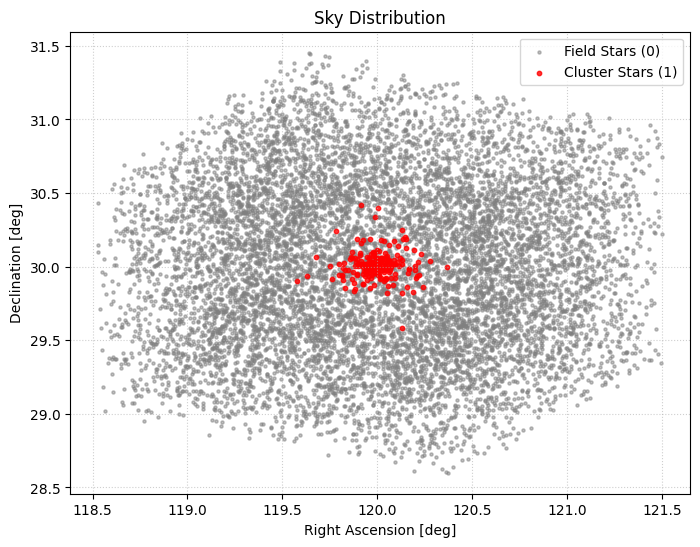

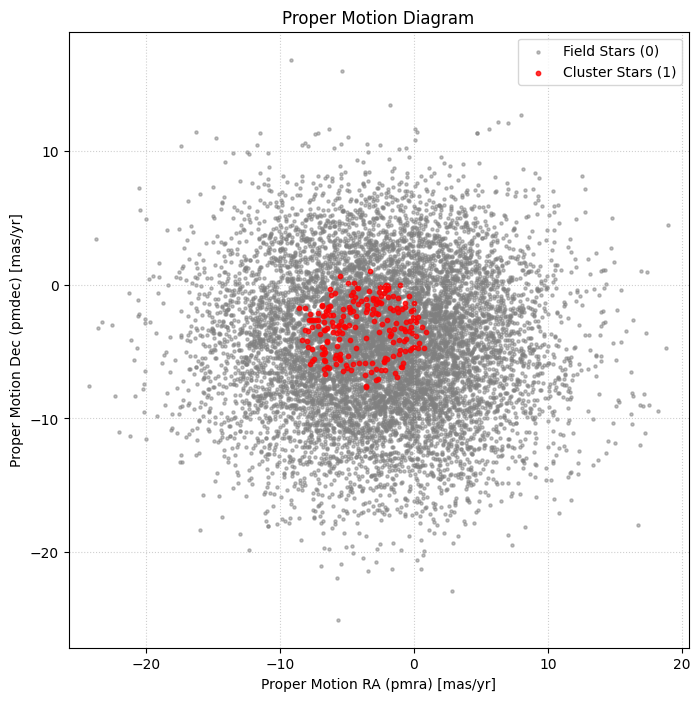

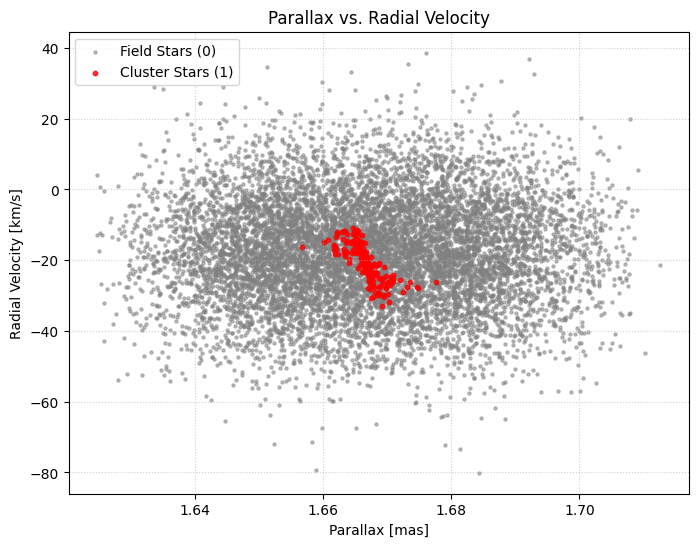

In [88]:
# --- Parameters for Observer Frame ---
np.random.seed(420)
# Define the location and motion of the CLUSTER CENTER relative to Earth
cluster_center_RA_deg = 120.0   # Right Ascension of cluster center [degrees]
cluster_center_DEC_deg = 30.0    # Declination of cluster center [degrees]
cluster_center_Dist_pc = 600.0   # Distance to cluster center [pc]

# Systemic velocity of the cluster center relative to Earth [km/s]
# (This is the velocity vector you add to the simulated velocities)
cluster_center_earth_VX = 10.0   # km/s
cluster_center_earth_VY = -5.0   # km/s
cluster_center_earth_VZ = -20.0  # km/s
cluster_center_earth_vel = np.array([
    cluster_center_earth_VX, cluster_center_earth_VY, cluster_center_earth_VZ
])

# --- Constants ---
# Astronomical unit in km
AU_km = 149597870.7
# Parsecs in km
PC_km = 3.085677581491367e13
# Seconds in a Julian year
SEC_PER_YEAR = 31557600.0
# Conversion factor for proper motion: km/s/pc -> mas/yr
# 1 km/s at 1 pc = (1 km/s) / (1 pc in km) rad/s
# rad/s * (sec/yr) * (180/pi deg/rad) * (3600 arcsec/deg) * (1000 mas/arcsec)
# = (1 / PC_km) * SEC_PER_YEAR * (180/np.pi) * 3600 * 1000
PM_CONVERSION_FACTOR = SEC_PER_YEAR * np.degrees(1) * 3600 * 1000 / PC_km
# Alternatively, the standard approximation: 1 / 4.74047
# PM_CONVERSION_FACTOR = 1.0 / 4.740470463 # mas/yr per km/s/pc
print(f"Using Proper Motion Conversion Factor (km/s/pc -> mas/yr): {PM_CONVERSION_FACTOR:.6f}")
# Let's use the more direct calculation based on constants above.


# --- Coordinate Transformations ---

print("Performing coordinate transformations...")

# 1. Convert cluster center spherical coords to Cartesian observer frame
ra_rad_c = np.radians(cluster_center_RA_deg)
dec_rad_c = np.radians(cluster_center_DEC_deg)

X_c = cluster_center_Dist_pc * np.cos(dec_rad_c) * np.cos(ra_rad_c)
Y_c = cluster_center_Dist_pc * np.cos(dec_rad_c) * np.sin(ra_rad_c)
Z_c = cluster_center_Dist_pc * np.sin(dec_rad_c)
cluster_center_earth_vec = np.array([X_c, Y_c, Z_c])

# 2. Calculate absolute positions for all stars in observer frame
# Assumes simulation (x,y,z) align directly with observer (X,Y,Z)
X_abs = X_c + df['x'].values
Y_abs = Y_c + df['y'].values
Z_abs = Z_c + df['z'].values

# 3. Calculate distance (d) and parallax (plx)
d = np.sqrt(X_abs**2 + Y_abs**2 + Z_abs**2)
# Add small epsilon to avoid division by zero if d is exactly 0 (highly unlikely)
epsilon = 1e-10
plx_mas = 1000.0 / (d + epsilon)

# 4. Calculate RA and Dec for each star
# Use arctan2 for quadrant correctness in RA
ra_rad = np.arctan2(Y_abs, X_abs)
# Ensure RA is in [0, 2*pi) range
ra_rad = ra_rad % (2 * np.pi)
dec_rad = np.arcsin(Z_abs / (d + epsilon))

# Convert to degrees
ra_deg = np.degrees(ra_rad)
dec_deg = np.degrees(dec_rad)

# 5. Calculate absolute velocities for all stars in observer frame
VX_abs = cluster_center_earth_vel[0] + df['vx'].values
VY_abs = cluster_center_earth_vel[1] + df['vy'].values
VZ_abs = cluster_center_earth_vel[2] + df['vz'].values

# 6. Calculate Radial Velocity (RV)
# RV = V_abs dotted with position_unit_vector
rv_kms = (VX_abs * X_abs + VY_abs * Y_abs + VZ_abs * Z_abs) / (d + epsilon)

# 7. Calculate Proper Motions (PM_RA, PM_DEC)

# Calculate unit vectors in RA and Dec directions
# Unit vector in RA direction: u_ra = (-sin(ra), cos(ra), 0)
u_ra_X = -np.sin(ra_rad)
u_ra_Y = np.cos(ra_rad)
u_ra_Z = 0.0
# Unit vector in Dec direction: u_dec = (-cos(ra)sin(dec), -sin(ra)sin(dec), cos(dec))
u_dec_X = -np.cos(ra_rad) * np.sin(dec_rad)
u_dec_Y = -np.sin(ra_rad) * np.sin(dec_rad)
u_dec_Z = np.cos(dec_rad)

# Project absolute velocity vector onto RA and Dec unit vectors
v_ra_kms = VX_abs * u_ra_X + VY_abs * u_ra_Y + VZ_abs * u_ra_Z
v_dec_kms = VX_abs * u_dec_X + VY_abs * u_dec_Y + VZ_abs * u_dec_Z

# Convert transverse velocities to proper motions (mas/yr)
# pm = v_transverse [km/s] / (d [pc] * 4.74047) -> Standard approx
# Using our constant: pm = v_transverse [km/s] * PM_CONVERSION_FACTOR / d [pc]

# pm_ra*cos(dec) [mas/yr]
pm_ra_cosdec = v_ra_kms * PM_CONVERSION_FACTOR / (d + epsilon)
# pm_dec [mas/yr]
pm_dec = v_dec_kms * PM_CONVERSION_FACTOR / (d + epsilon)

# Correct pm_ra*cos(dec) to pm_ra by dividing by cos(dec)
# Avoid division by zero near poles |dec| ~ 90 deg
cos_dec = np.cos(dec_rad)
# Set pm_ra to 0 or handle appropriately if cos(dec) is very close to zero
safe_cos_dec = np.where(np.abs(cos_dec) < epsilon, epsilon, cos_dec)
pm_ra = pm_ra_cosdec / safe_cos_dec


# --- Update DataFrame ---
print("Adding new columns to DataFrame...")

df_obs = df.copy() # Create a copy to keep original simulation data separate

df_obs['ra'] = ra_deg          # RA [deg]
df_obs['dec'] = dec_deg         # Dec [deg]
df_obs['parallax'] = plx_mas    # Parallax [mas]
df_obs['pmra'] = pm_ra          # Proper Motion RA [mas/yr]
df_obs['pmdec'] = pm_dec        # Proper Motion Dec [mas/yr]
df_obs['radial_velocity'] = rv_kms # Radial Velocity [km/s]

# Optionally remove intermediate or original columns if desired
# df_obs = df_obs.drop(columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])

print("Transformation complete.")
print("\nDataFrame with Observable Coordinates (Head):")
print(df_obs[['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity', 'label']].head())

# --- Optional: Visualization in Observable Space ---
print("\nGenerating visualizations in observable space...")

# Separate cluster and field stars for plotting
cluster_stars_obs = df_obs[df_obs['label'] == 1]
field_stars_obs = df_obs[df_obs['label'] == 0]

# 1. Sky Plot (RA vs Dec)
plt.figure(figsize=(8, 6))
plt.scatter(field_stars_obs['ra'], field_stars_obs['dec'], s=5, alpha=0.5, label='Field Stars (0)', c='grey')
plt.scatter(cluster_stars_obs['ra'], cluster_stars_obs['dec'], s=10, alpha=0.8, label='Cluster Stars (1)', c='red')
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.title('Sky Distribution')
# Invert RA axis for typical sky plots
# plt.xlim(plt.xlim()[::-1]) # Uncomment if desired
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
# plt.xlim(115,125)
# plt.ylim(25,35)
plt.show()

# 2. Proper Motion Diagram (PM_RA vs PM_DEC)
plt.figure(figsize=(8, 8))
plt.scatter(field_stars_obs['pmra'], field_stars_obs['pmdec'], s=5, alpha=0.5, label='Field Stars (0)', c='grey')
plt.scatter(cluster_stars_obs['pmra'], cluster_stars_obs['pmdec'], s=10, alpha=0.8, label='Cluster Stars (1)', c='red')
plt.xlabel('Proper Motion RA (pmra) [mas/yr]')
plt.ylabel('Proper Motion Dec (pmdec) [mas/yr]')
plt.title('Proper Motion Diagram')
plt.legend()
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 3. Parallax vs. Radial Velocity (Color by Label)
plt.figure(figsize=(8, 6))
plt.scatter(field_stars_obs['parallax'], field_stars_obs['radial_velocity'], s=5, alpha=0.5, label='Field Stars (0)', c='grey')
plt.scatter(cluster_stars_obs['parallax'], cluster_stars_obs['radial_velocity'], s=10, alpha=0.8, label='Cluster Stars (1)', c='red')
plt.xlabel('Parallax [mas]')
plt.ylabel('Radial Velocity [km/s]')
plt.title('Parallax vs. Radial Velocity')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
# Optionally set xlim for parallax if needed, e.g., plt.xlim(0, 1000/cluster_center_Dist_pc + 5)
plt.show()

## plot the results

In [89]:
cluster = df_obs[df_obs['label']==1]
cluster

,x,y,z,vx,vy,vz,label,ra,dec,parallax,pmra,pmdec,radial_velocity
165,-0.765563,-0.600363,0.266061,-2.327074,-5.400068,3.288014,1,120.106234,30.028508,1.666625,-0.577079,-2.826789,-19.484822
167,-0.296773,0.198223,-0.855382,2.403730,1.244718,-10.482811,1,120.017400,29.913956,1.667083,-3.595284,-7.633247,-23.398601
210,0.250408,-0.199456,-0.072456,12.221920,-7.754783,-2.873436,1,119.987077,30.008237,1.667484,-5.228820,-3.069964,-30.623919
214,-0.108714,0.858552,-1.274431,6.123198,4.489658,-1.911627,1,119.963104,29.856517,1.666512,-5.558728,-5.193963,-18.275531
272,0.476439,-1.014227,-0.686732,8.303075,-12.785450,-1.102133,1,120.010443,29.996512,1.670314,-2.829102,-2.113827,-31.816351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10034,1.553498,0.065030,-0.724538,12.450898,-1.478643,-0.916961,1,119.847856,29.974350,1.669406,-6.605530,-3.426273,-24.997319
10083,-0.522183,-0.460183,-0.089026,-1.756180,-10.554083,1.925300,1,120.075256,29.999178,1.667120,0.268333,-2.411757,-24.271754
10086,0.563416,-0.199487,0.457351,8.457101,-6.552948,4.112743,1,119.957159,30.059531,1.667124,-4.153574,-1.448982,-24.598178
10144,0.304624,0.781636,0.540017,7.175875,6.066090,8.078368,1,119.927890,30.019568,1.664656,-6.252733,-2.281652,-12.584041


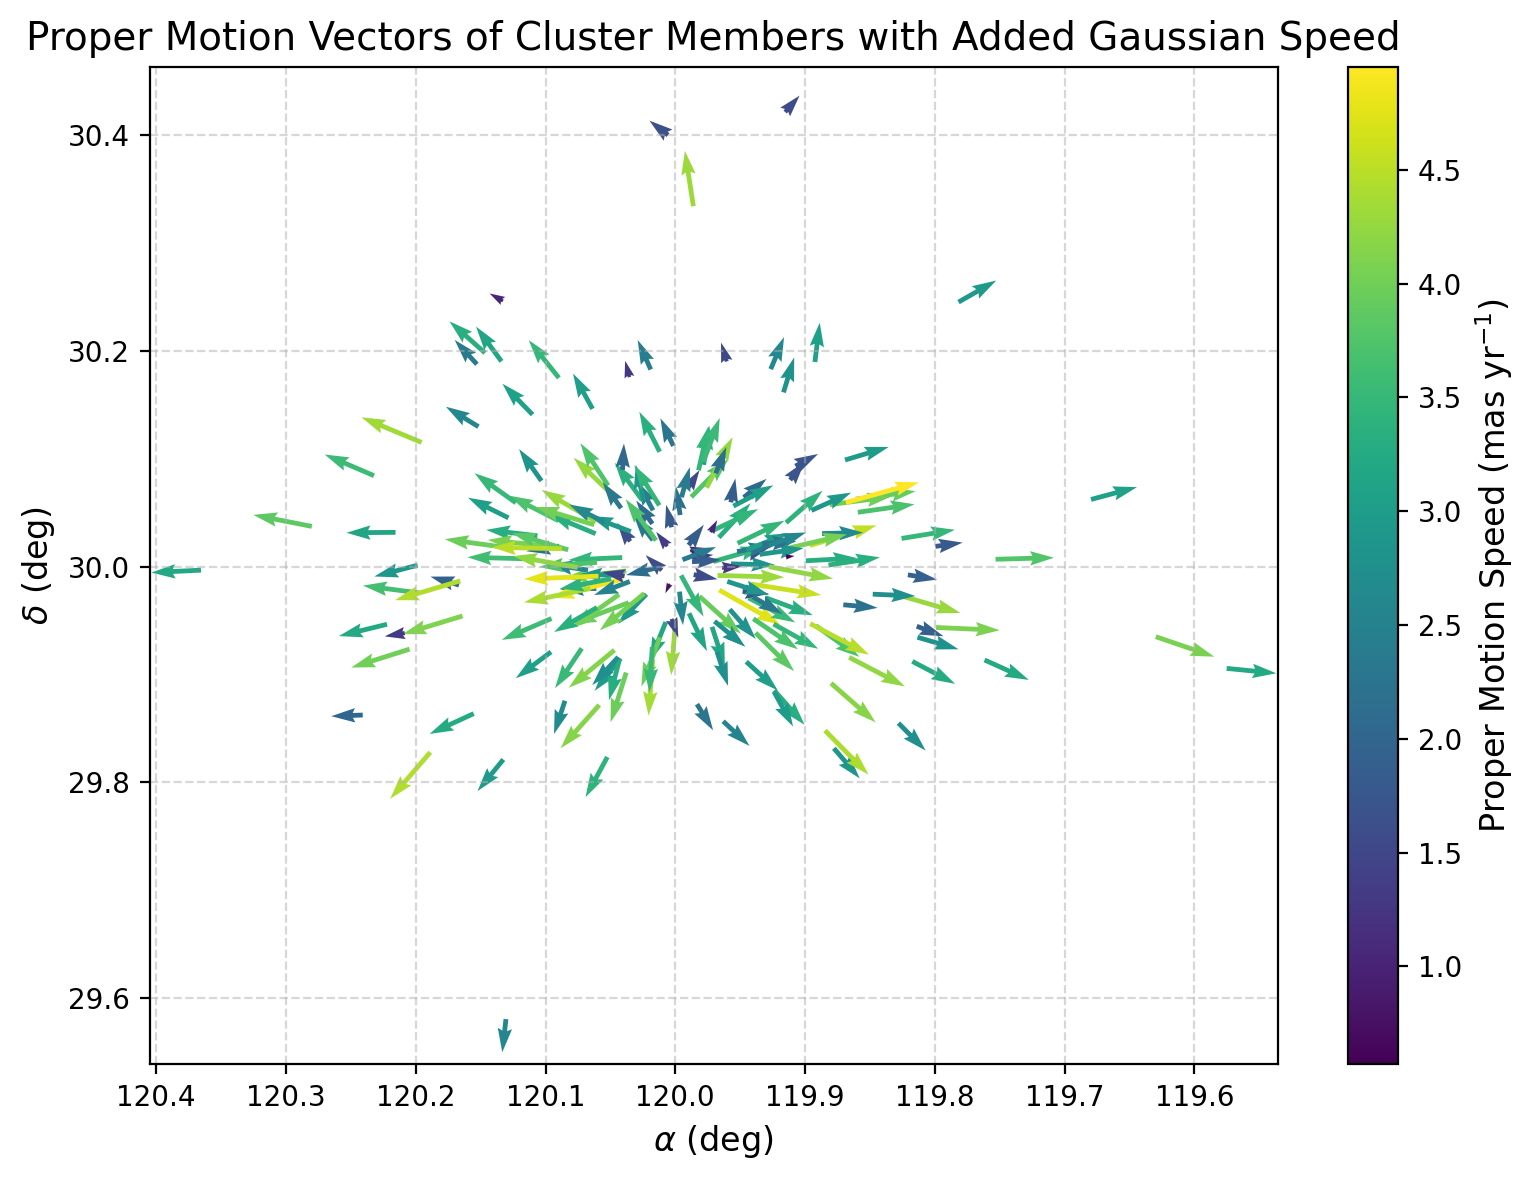

In [90]:
# Calculate the normalized velocity vectors
x_mean = np.mean(cluster["pmra"]).item()
y_mean = np.mean(cluster["pmdec"]).item()

vx_normalized = cluster["pmra"] - x_mean
vy_normalized = cluster["pmdec"] - y_mean

# Plot with scientific style
with plt.style.context([]):
    plt.figure(figsize=(8, 6), dpi=200)
    ax = plt.gca()

    # Compute the speed for color mapping
    speed = np.sqrt(vx_normalized**2 + vy_normalized**2)

    # Create a quiver plot
    q = ax.quiver(cluster["ra"], cluster["dec"], vx_normalized, vy_normalized, speed,
                  cmap='viridis',  # "viridis" is a good perceptually uniform colormap for scientific plots
                  clim=[np.min(speed), np.max(speed)], angles='xy', scale_units='xy')

    # Add colorbar with a label
    cbar = plt.colorbar(q)
    cbar.set_label('Proper Motion Speed (mas yr$^{-1}$)', fontsize=12)

    # Axis labels and title
    ax.set_xlabel(r'$\alpha$ (deg)', fontsize=12)
    ax.set_ylabel(r'$\delta$ (deg)', fontsize=12)
    if Speed_selection==0:
        ax.set_title("Proper Motion Vectors of Cluster Members with Default Speed", fontsize=14)
    elif Speed_selection==1:
        ax.set_title("Proper Motion Vectors of Cluster Members with Added Constant Speed", fontsize=14)
    else:
        ax.set_title("Proper Motion Vectors of Cluster Members with Added Gaussian Speed", fontsize=14)

    

    # Invert x-axis (RA convention)
    ax.invert_xaxis()

    # Set grid for better readability
    ax.grid(True, linestyle='--', alpha=0.5)

    #plt.ylim(7.5, 13.5)
    # Display the plot
    plt.tight_layout()